# Introduction to ProxBTF.jl
Welcome! In this tutorial, we provide a few examples of using pbsrtf using the Julia package ProxBTF.jl. The usage of pbtf is identical to that in [Introduction_to_pbtf](https://github.com/qhengncsu/ProxBTF.jl/blob/main/vignettes/Introduction_to_pbtf.ipynb), however, we present it here again for completeness.

## Proximal Bayesian trend filtering
Function ProxBTF.pbtf is the main interface for fitting a proximal Bayesian trend filtering model. All you need is only a vector of responses $\mathbf{y}\in\mathbb{R}^m$, and a vector of predictors $\mathbf{x}\in\mathbb{R}^m$(repititions are allowed).

### Piecewise linear example 
We fit a pbtf model on a sequence generated by a piecewise linear underlying trend. Besides the predictor $\mathbf{x}$ and the response $\mathbf{y}$, we set the third positional argument $k$ to be 1 to fit a piecewise linear model.

In [2]:
# activate your main environment, v1.6
# you may also create and use another dedicated environment to avoid messing things up in your main environment
using Pkg
Pkg.activate()
#this will take longer than you expect the first time you run it since 
# a lot of packages will be installed and precompiled
Pkg.add("Random")
Pkg.add("StatsPlots")
Pkg.add(url="https://github.com/qhengncsu/ProxBTF.jl")

    Fetching: [====================>                    

    Fetching: [

In [3]:
Pkg.status()

In [4]:
using ProxBTF,Random,StatsPlots

Warmup: 100%|███████████████████████████████████████████| Time: 0:00:01
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:03
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:06
MCMC: 100%|█████████████████████████████████████████████| Time: 0:00:50


Hamiltonian Monte Carlo sample of length 3000
  acceptance rate mean: 0.96, 5/25/50/75/95%: 0.82 0.94 0.98 1.0 1.0
  termination: divergence => 0%, max_depth => 100%, turning => 0%
  depth: 0 => 0%, 1 => 0%, 2 => 0%, 3 => 0%, 4 => 0%, 5 => 0%, 6 => 0%, 7 => 0%, 8 => 0%, 9 => 0%, 10 => 100%


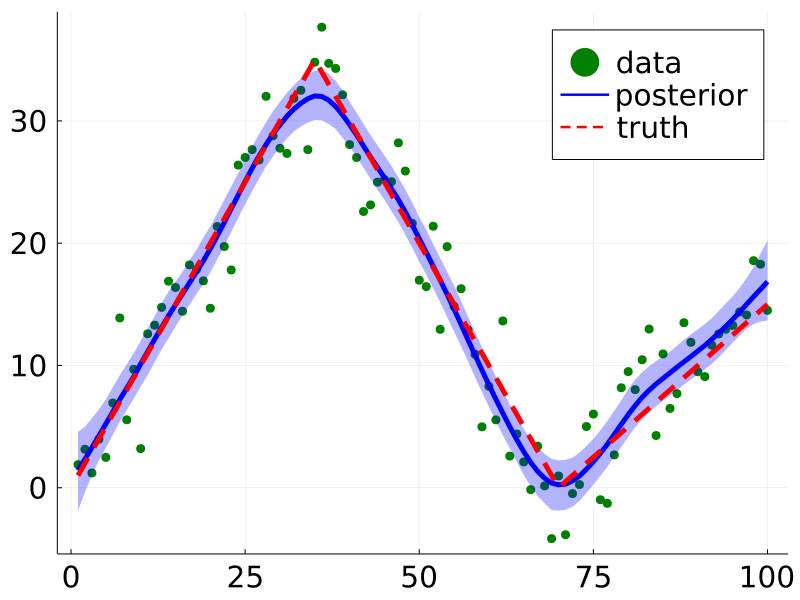

In [5]:
Random.seed!(1)
x = [1:1.:100;]
fx = map(xi -> 0 ≤ xi ≤ 35 ? xi : 35 < xi ≤ 70 ? 70-xi : 0.5xi-35, x)
σ = 3.0
y = fx .+  σ.*randn(100)
result_summary,result_quantile,result_matrix,problem,elapse_time=pbtf(y,x,1)
visualize(result_quantile,problem;legend_position=:topright)
plot!(subplot=1,x,fx,linewidth=5,line=:dash,c=:red,label="truth")

### Tuning the hyperparameter $s_2$.
By default, the second shape parameter $s_2$ of the beta prime prior for $\alpha$ in pbtf is set to be $\sqrt{n}$, where $n$ is the number of distinct values of $\mathbf{x}$. If more or less regularity is desired, one can always increase or decrease $s_2$. Here we increase $s_2$ from the default value $\sqrt{n}=10$ to be 20 to promote a bit more regularity.

In [6]:
result_summary,result_quantile,result_matrix,problem,elapse_time=pbtf(y,x,1;s₂=20.0)
visualize(result_quantile,problem;legend_position=:topright)
plot!(subplot=1,x,fx,linewidth=5,line=:dash,c=:red,label="truth")

LoadError: syntax: unexpected ","

### Piecewise quadratic example
Now we fit a pbtf model on a sequence generated by a sinuoid underlying trend. We set the third positional argument $k$ to be 2 to tell pbtf function to fit a piecewise quadratic model. Notice that a quadratic model will take much longer to fit since we need to apply the difference epigraph projection technique to reduce numerical instability.

Warmup: 100%|███████████████████████████████████████████| Time: 0:00:11
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:04
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:10
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:22
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:48
Warmup: 100%|███████████████████████████████████████████| Time: 0:01:35
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:11
MCMC: 100%|█████████████████████████████████████████████| Time: 0:04:25


Hamiltonian Monte Carlo sample of length 1000
  acceptance rate mean: 0.93, 5/25/50/75/95%: 0.74 0.9 0.97 0.99 1.0
  termination: divergence => 0%, max_depth => 99%, turning => 1%
  depth: 0 => 0%, 1 => 0%, 2 => 0%, 3 => 0%, 4 => 0%, 5 => 0%, 6 => 0%, 7 => 0%, 8 => 0%, 9 => 0%, 10 => 100%


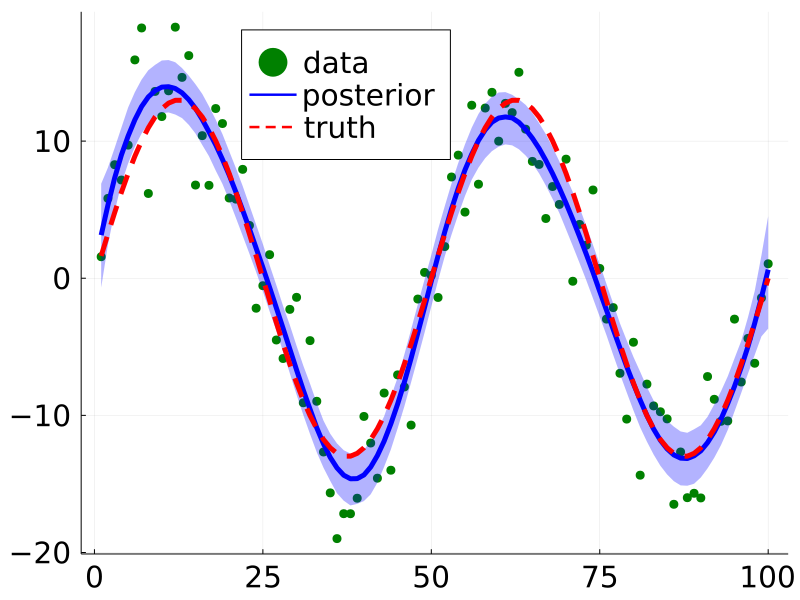

In [7]:
fx  = 13 .* sin.((4*π/100).*x)
y = fx .+  σ.*randn(100)
result_summary,result_quantile,result_matrix,problem,elapse_time=pbtf(y,x,2;nsample=1000)
visualize(result_quantile,problem;legend_position=:top)
plot!(subplot=1,x,fx,linewidth=5,line=:dash,c=:red,label="truth")

## Applying the thinning technique
When the sequence is too long or there are two grid locations too close to each other, pbtf will experience numerical instability. Therefore we apply a preprocessing technique called thinning to make our method applicable in those cases.
Here we return to the sinuoid underlying trend. The difference is that this time we uniformly generate 1000 values from 0 to 100 as our predictor. This will make the difference matrix extremely ill-conditioned. Without thinning, not only does it take 2 hours to run, the HMC sampler struggles to explore the parameter space and the effective sample size will be smaller than 10. After thinning, the HMC sampler can function normally.

In [8]:
x = sort(100*rand(1000))
σ = 3.0
fx  = 13 .* sin.((4*π/100).*x)
y = fx .+  σ.*randn(1000)
result_summary,result_quantile,result_matrix,problem,elapse_time=pbtf(y,x,2;thinning=true)
result_summary

┌ Warning: Transformation matrix is likely too ill-conditioned, setting thinning=true is recommended.
└ @ ProxBTF C:\Users\19199\.julia\packages\ProxBTF\RXCKM\src\model_pbtf.jl:34
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:05
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:10
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:22
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:46
Warmup: 100%|███████████████████████████████████████████| Time: 0:01:36
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:10
MCMC: 100%|█████████████████████████████████████████████| Time: 0:13:00


Hamiltonian Monte Carlo sample of length 3000
  acceptance rate mean: 0.95, 5/25/50/75/95%: 0.79 0.92 0.98 1.0 1.0
  termination: divergence => 0%, max_depth => 100%, turning => 0%
  depth: 0 => 0%, 1 => 0%, 2 => 0%, 3 => 0%, 4 => 0%, 5 => 0%, 6 => 0%, 7 => 0%, 8 => 0%, 9 => 0%, 10 => 100%


,parameters,mean,std,naive_se,mcse,ess,rhat
,Symbol,Float64,Float64,Float64,Float64,Float64,Float64
1,β[1],0.634307,0.771844,0.0140919,0.0422716,298.765,0.999854
2,β[2],3.03233,0.498175,0.00909539,0.020589,437.795,0.999863
3,β[3],4.41113,0.423977,0.00774073,0.0143348,621.793,0.999762
4,β[4],5.93319,0.39174,0.00715216,0.0134847,748.98,0.999669
5,β[5],7.08663,0.382696,0.00698704,0.014366,723.772,0.999731
6,β[6],8.68538,0.373787,0.00682438,0.0147865,730.999,0.999974
7,β[7],9.82551,0.366225,0.00668632,0.0141879,801.718,1.00013
8,β[8],10.556,0.362477,0.00661789,0.0134141,831.464,1.00031
9,β[9],11.4278,0.359807,0.00656915,0.0120317,895.633,1.00007


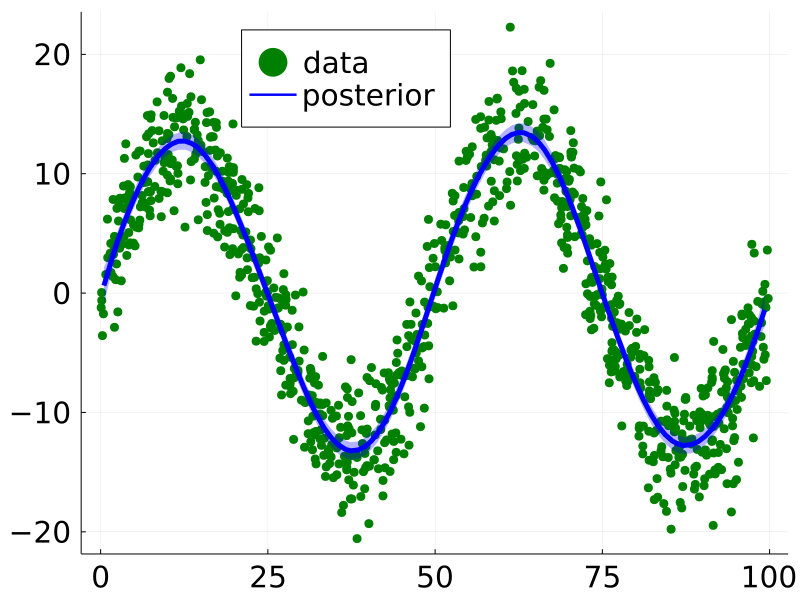

In [9]:
visualize(result_quantile,problem;legend_position=:top)

## Proximal Bayesian shape-restricted trend filtering
Function ProxBTF.pbsrtf is the main interface for fitting a proximal Bayesian shape-restricted trend filtering model. Besides predictor $\mathbf{x}$, response $\mathbf{y}$ and order $k$, you also need to specify a shape restriction, which is one of "increasing", "decreasing", "convex","concave","inc-convex","inc-concave","dec-convex", and "dec-concave".

### Convex-linear example
Now we fit a pbsrtf model on a sequence generated by the convex-linear underlying trend. We set the third positional argument $k$ to be 1 to tell pbsrtf function to fit a piecewise linear model. We set the fourth positional argument restriction to be "convex" to enforce the convexity shape restriction.

Academic license - for non-commercial use only - expires 2023-09-04


Warmup: 100%|███████████████████████████████████████████| Time: 0:00:37
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:45
Warmup: 100%|███████████████████████████████████████████| Time: 0:02:08
Warmup: 100%|███████████████████████████████████████████| Time: 0:02:41
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:49
MCMC: 100%|█████████████████████████████████████████████| Time: 0:11:06


Hamiltonian Monte Carlo sample of length 1000
  acceptance rate mean: 0.84, 5/25/50/75/95%: 0.58 0.77 0.88 0.95 0.99
  termination: divergence => 0%, max_depth => 0%, turning => 100%
  depth: 0 => 0%, 1 => 0%, 2 => 0%, 3 => 0%, 4 => 39%, 5 => 18%, 6 => 20%, 7 => 18%, 8 => 4%


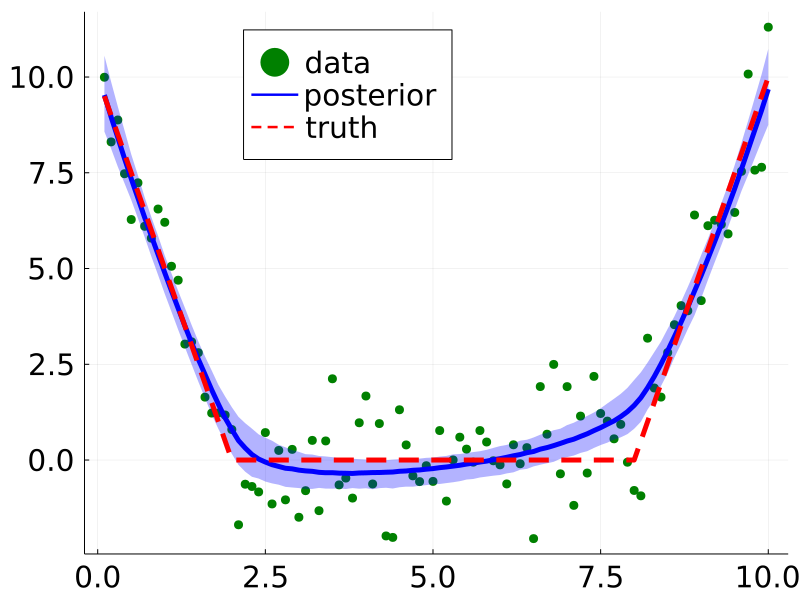

In [13]:
x = [0.1:0.1:10;]
fx = map(xi -> 0 ≤ xi ≤ 2 ? 10-5xi : 2 < xi ≤ 8 ? 0 : 5xi-40, x)
σ = 1.0
y = fx .+  σ.*randn(100)
result_summary,result_quantile,result_matrix,problem,elapse_time=pbsrtf(y,x,1,"convex")
visualize(result_quantile,problem;legend_position=:top)
plot!(subplot=1,x,fx,linewidth=5,line=:dash,c=:red,label="truth")

### Tuning the hyperparameter $\mu$
By default, the rate parameter $\mu$ of the exponential prior for $\alpha$ in pbsrtf is set to be 3. Similar to $s_2$, ff more or less regularity is desired, one can always increase or decrease $\mu$. Again, here we increase $\mu$ from 3 to 4 to promote a bit more regularity.

Academic license - for non-commercial use only - expires 2023-09-04


Warmup: 100%|███████████████████████████████████████████| Time: 0:00:43
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:45
Warmup: 100%|███████████████████████████████████████████| Time: 0:02:14
Warmup: 100%|███████████████████████████████████████████| Time: 0:02:35
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:56
MCMC: 100%|█████████████████████████████████████████████| Time: 0:17:10


Hamiltonian Monte Carlo sample of length 1000
  acceptance rate mean: 0.9, 5/25/50/75/95%: 0.71 0.84 0.92 0.97 1.0
  termination: divergence => 0%, max_depth => 0%, turning => 100%
  depth: 0 => 0%, 1 => 0%, 2 => 0%, 3 => 0%, 4 => 13%, 5 => 26%, 6 => 19%, 7 => 24%, 8 => 17%


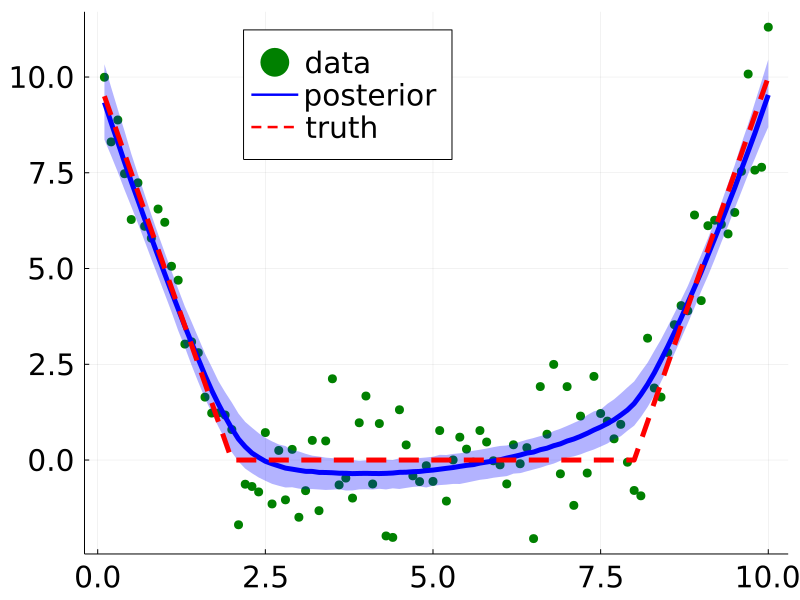

In [14]:
result_summary,result_quantile,result_matrix,problem,elapse_time=pbsrtf(y,x,1,"convex";μ=4.0)
visualize(result_quantile,problem;legend_position=:top)
plot!(subplot=1,x,fx,linewidth=5,line=:dash,c=:red,label="truth")

Now let's do a real data example. The data set is copied from [spmrf](https://github.com/jrfaulkner/spmrf).

In [15]:
Pkg.add("RData")
using RData
data_munich = load("../data/munich.rda")["munich"]
x = float(data_munich[:,"fsize"])
y = data_munich[:,"rent"]

2035-element Vector{Float64}:
 12.9
 10.89
  3.32
  9.27
  4.5
  6.76
  8.0
  6.15
 10.23
  9.03
  2.54
  6.35
  8.76
  ⋮
  6.95
 11.0
  6.06
  7.82
  5.73
  7.77
  7.99
 11.59
  9.73
  6.47
 11.12
  7.19

Warmup: 100%|███████████████████████████████████████████| Time: 0:00:02
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:04
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:09
MCMC: 100%|█████████████████████████████████████████████| Time: 0:03:58


Hamiltonian Monte Carlo sample of length 10000
  acceptance rate mean: 0.94, 5/25/50/75/95%: 0.76 0.91 0.97 1.0 1.0
  termination: divergence => 0%, max_depth => 100%, turning => 0%
  depth: 0 => 0%, 1 => 0%, 2 => 0%, 3 => 0%, 4 => 0%, 5 => 0%, 6 => 0%, 7 => 0%, 8 => 0%, 9 => 0%, 10 => 100%


Warmup: 100%|███████████████████████████████████████████| Time: 0:00:14
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:04
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:10
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:29
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:56
Warmup: 100%|███████████████████████████████████████████| Time: 0:01:57
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:14
MCMC: 100%|█████████████████████████████████████████████| Time: 0:15:44


Hamiltonian Monte Carlo sample of length 3000
  acceptance rate mean: 0.91, 5/25/50/75/95%: 0.65 0.86 0.96 0.99 1.0
  termination: divergence => 0%, max_depth => 100%, turning => 0%
  depth: 0 => 0%, 1 => 0%, 2 => 0%, 3 => 0%, 4 => 0%, 5 => 0%, 6 => 0%, 7 => 0%, 8 => 0%, 9 => 0%, 10 => 100%


Warmup:  28%|█████████████                              |  ETA: 0:00:13

Academic license - for non-commercial use only - expires 2023-09-04


Warmup: 100%|███████████████████████████████████████████| Time: 0:00:35
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:56
Warmup: 100%|███████████████████████████████████████████| Time: 0:04:06
Warmup: 100%|███████████████████████████████████████████| Time: 0:07:00
Warmup: 100%|███████████████████████████████████████████| Time: 0:02:26
MCMC: 100%|█████████████████████████████████████████████| Time: 0:43:18


Hamiltonian Monte Carlo sample of length 1000
  acceptance rate mean: 0.83, 5/25/50/75/95%: 0.54 0.76 0.86 0.95 0.99
  termination: divergence => 0%, max_depth => 0%, turning => 100%
  depth: 0 => 0%, 1 => 0%, 2 => 0%, 3 => 0%, 4 => 0%, 5 => 2%, 6 => 14%, 7 => 46%, 8 => 36%, 9 => 2%


Warmup:  18%|████████                                   |  ETA: 0:00:06

Academic license - for non-commercial use only - expires 2023-09-04


Warmup: 100%|███████████████████████████████████████████| Time: 0:00:11
Warmup: 100%|███████████████████████████████████████████| Time: 0:00:12
Warmup: 100%|███████████████████████████████████████████| Time: 0:02:07
Warmup: 100%|███████████████████████████████████████████| Time: 0:05:26
Warmup: 100%|███████████████████████████████████████████| Time: 0:01:01
MCMC: 100%|█████████████████████████████████████████████| Time: 0:16:55


Hamiltonian Monte Carlo sample of length 1000
  acceptance rate mean: 0.9, 5/25/50/75/95%: 0.71 0.86 0.93 0.97 1.0
  termination: divergence => 0%, max_depth => 0%, turning => 100%
  depth: 0 => 0%, 1 => 0%, 2 => 0%, 3 => 0%, 4 => 0%, 5 => 68%, 6 => 20%, 7 => 9%, 8 => 2%


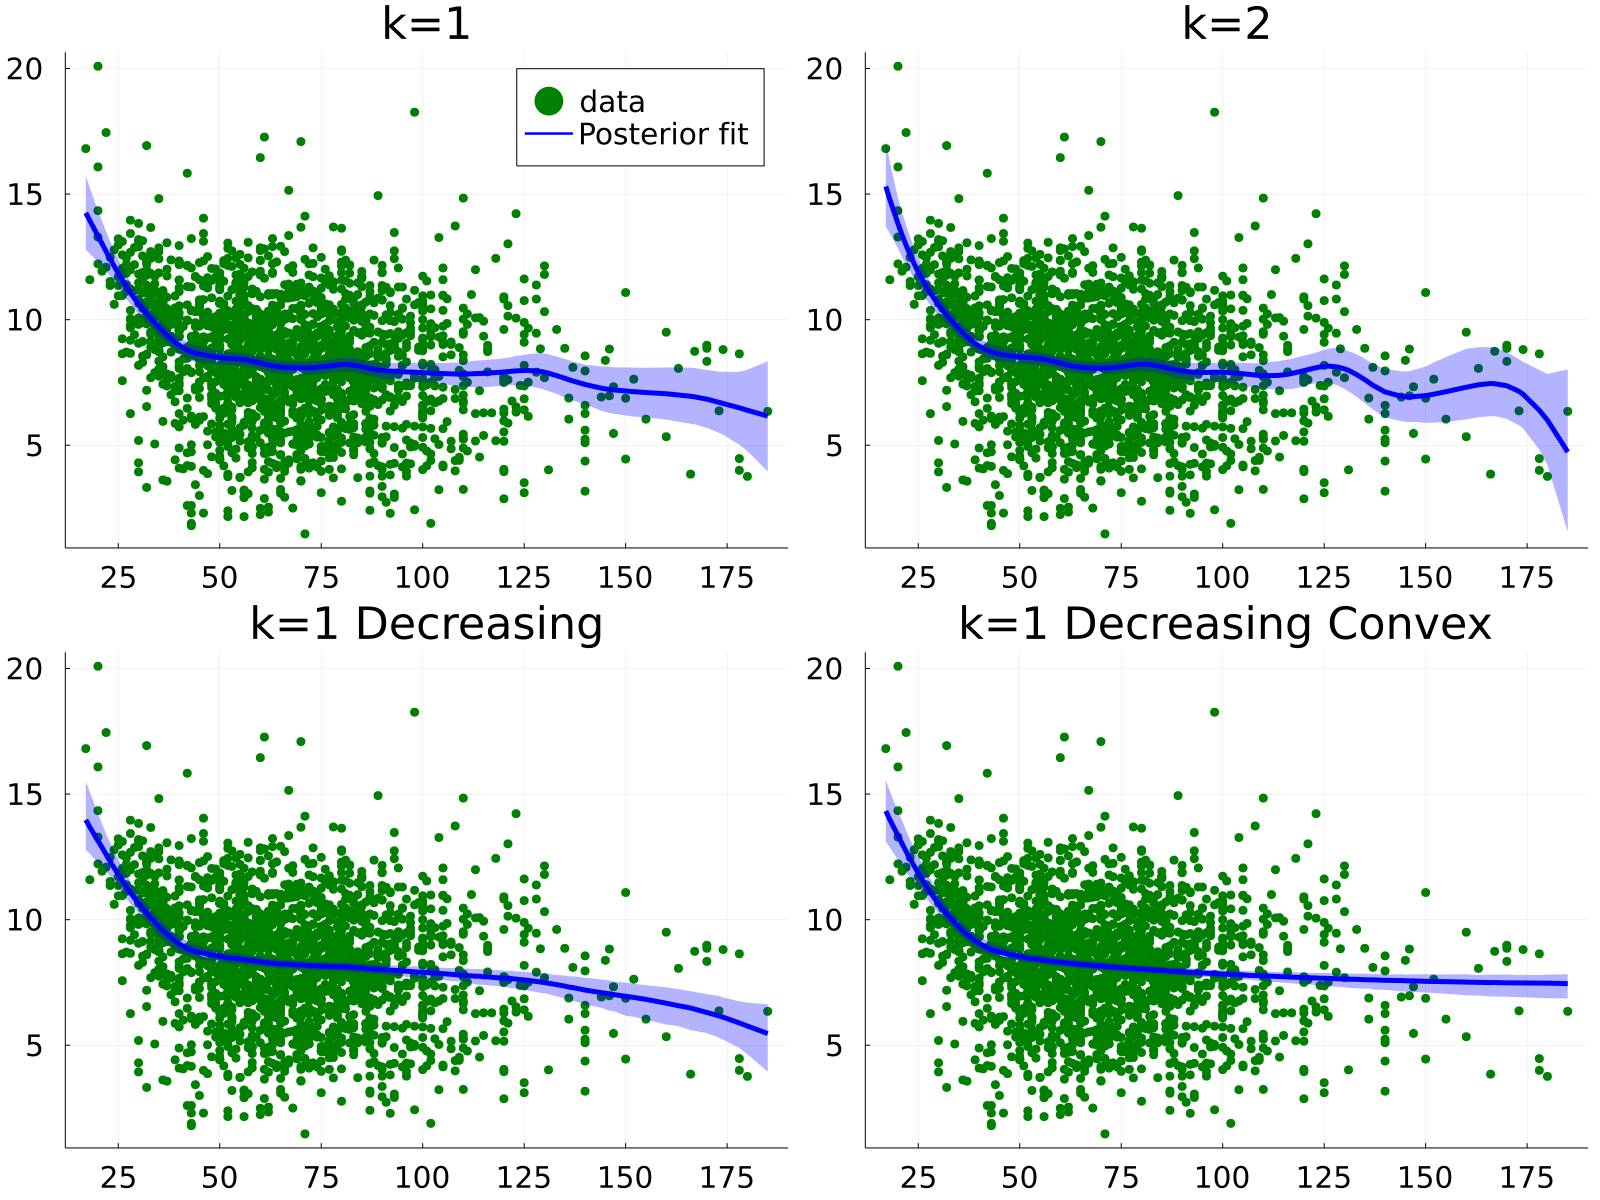

In [16]:
result_summary,result_quantile1,result_matrix1,problem1,elapse_time=pbtf(y,x,1,nsample=10000,s₂=2*sqrt(134))
result_summary,result_quantile2,result_matrix2,problem2,elapse_time=pbtf(y,x,2,nsample=3000,s₂=2*sqrt(134))
result_summary,result_quantile3,result_matrix3,problem3,elapse_time=pbsrtf(y,x,1,"decreasing",μ=4.0)
result_summary,result_quantile4,result_matrix4,problem4,elapse_time=pbsrtf(y,x,1,"dec-convex",μ=4.0)
n = 134
plt=plot(layout=(2,2),size=(1600,1200))
scatter!(subplot=1,x,y,markersize=5,markercolor=:green,label="data",legendfontsize=20,
          title="k=1",titlefontsize=30,xtickfontsize=20,ytickfontsize=20,markerstrokewidth=0)
plot!(subplot=1,problem1.xgrid,result_quantile1[1:n, Symbol("50.0%")],linewidth=5,label="Posterior fit",c=:blue,
      ribbon=(result_quantile1[1:n, Symbol("50.0%")] .- result_quantile1[1:n, Symbol("2.5%")],
      result_quantile1[1:n, Symbol("97.5%")] .- result_quantile1[1:n, Symbol("50.0%")]),fillalpha=0.3)
scatter!(subplot=2,x,y,markersize=5,markercolor=:green,label=nothing,
      title="k=2",titlefontsize=30,xtickfontsize=20,ytickfontsize=20,markerstrokewidth=0)
plot!(subplot=2,problem2.xgrid,result_quantile2[1:n, Symbol("50.0%")],linewidth=5,label=nothing,c=:blue,
      ribbon=(result_quantile2[1:n, Symbol("50.0%")] .- result_quantile2[1:n, Symbol("2.5%")],
      result_quantile2[1:n, Symbol("97.5%")] .- result_quantile2[1:n, Symbol("50.0%")]),fillalpha=0.3)
scatter!(subplot=3,x,y,markersize=5,markercolor=:green,label=nothing,
      title="k=1 Decreasing",titlefontsize=30,xtickfontsize=20,ytickfontsize=20,markerstrokewidth=0)
plot!(subplot=3,problem3.xgrid,result_quantile3[1:n, Symbol("50.0%")],linewidth=5,label=nothing,c=:blue,
      ribbon=(result_quantile3[1:n, Symbol("50.0%")] .- result_quantile3[1:n, Symbol("2.5%")],
      result_quantile3[1:n, Symbol("97.5%")] .- result_quantile3[1:n, Symbol("50.0%")]),fillalpha=0.3)
scatter!(subplot=4,x,y,markersize=5,markercolor=:green,label=nothing,
     title="k=1 Decreasing Convex",titlefontsize=30,xtickfontsize=20,ytickfontsize=20,markerstrokewidth=0)
plot!(subplot=4,problem4.xgrid,result_quantile4[1:n, Symbol("50.0%")],linewidth=5,label=nothing,c=:blue,
      ribbon=(result_quantile4[1:n, Symbol("50.0%")] .- result_quantile4[1:n, Symbol("2.5%")],
      result_quantile4[1:n, Symbol("97.5%")] .- result_quantile4[1:n, Symbol("50.0%")]),fillalpha=0.3)